In [1]:
import copy
import sys
sys.path.insert(0, "..")
from classes.atoms import Atom, Atom_Collection, create_atom_col_copies, PBC_handler1
from classes.calculators.lennardjones import LennardJones
from classes.optimizers.random_struct_search import Line_searcher
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

In [22]:
pos_flat = np.loadtxt('../Week4/lj10clusters.txt')
positions = pos_flat.reshape(-1,pos_flat.shape[1]//2,2)[3]
atom_list = [Atom(position=pos, size=12) for pos in positions+np.array([6.0,6.0])]
unit_cell = (np.array([10.0,2.0]), np.array([5.0,10.0]))
atom_col_no_per = Atom_Collection(atomlist=atom_list, unit_cell=unit_cell, pbc=False)
atom_col_no_per.calculator = LennardJones()
#atom_col_no_per.positions
atom_list = [Atom(position=pos, size=12) for pos in positions+np.array([9.5,3.0])]
atom_col_per = Atom_Collection(atomlist=atom_list, unit_cell=unit_cell, pbc=True)
atom_col_per.calculator = LennardJones()
#print(atom_col_no_per.positions)
#print(atom_col_per.positions)

hsd


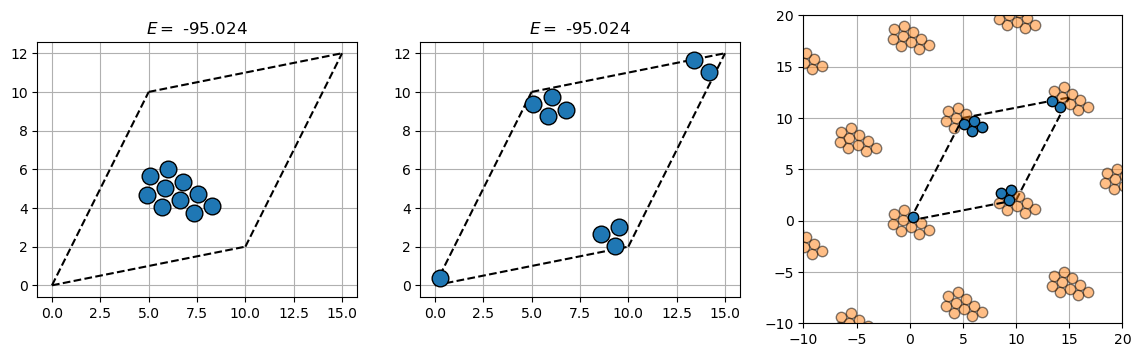

In [23]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
atom_cols = [atom_col_no_per, atom_col_per]
for ax, atom_col in zip(axs[0:2], atom_cols):
    ax.grid()
    #ax.set_xlim([-0.5,15.5])
    #ax.set_ylim([-0.5,12.5])
    atom_col.plot(ax=ax, plot_cell=True)
    atom_col.reset_plot_axes()
    ax.set_aspect("equal")
    ax.set_title(rf"$E=$ {atom_col.get_potential_energy().round(3)}")

atom_col_per.plot_cells(ax=axs[2], size=7.5)
atom_col_per.reset_plot_axes()
axs[2].grid()
axs[2].set_xlim([-10.0,20.0])
axs[2].set_ylim([-10.0,20.0])
atom_col_per.set_sizes([20 for i in range(len(atom_col_per))])

In [ ]:
points = atom_col_per.positions
print(points)
pbc_handler = PBC_handler1(unit_cell_vectors=unit_cell)
trans_mat = pbc_handler.trans_matrix
inv_mat = pbc_handler.inv_trans_matrix

In [ ]:
v1, v2 = unit_cell
center_vec = np.mean([v1, v2], axis=-1)
trans = pbc_handler.project_data(1/2*(v1+v2))
print(trans)
v1_t = pbc_handler.project_data(v1)
v2_t = pbc_handler.project_data(v2)
print(v1_t,v2_t)

In [ ]:
x_diffs = pdist(points[:,0].reshape(-1,1))
y_diffs = pdist(points[:,1].reshape(-1,1))
diff_vec = np.array([x_diffs, y_diffs]).T

In [ ]:
fig, ax = plt.subplots()
#ax.set_xlim([-4.0, 4.0])
#ax.set_ylim([-4.0, 4.0])
proj_diffs = pbc_handler.project_data(xy_pos=diff_vec)
proj_vectors = pbc_handler.project_data(points)
x_diffs_proj = pdist(proj_vectors[:,0].reshape(-1,1))
y_diffs_proj = pdist(proj_vectors[:,1].reshape(-1,1))
diff_vec_proj = np.array([x_diffs_proj, y_diffs_proj]).T
ax.plot(diff_vec_proj[:,0], diff_vec_proj[:,1], 'o',c="red")
ax.plot(proj_vectors[:,0], proj_vectors[:,1], 'o',c="blue")
#ax.plot(proj_diffs[:,0], proj_diffs[:,1], 'o', c="green")
ax.plot([0.0, v1_t[0]], [0.0, v1_t[1]], c='k')
ax.plot([0.0, v2_t[0]], [0.0, v2_t[1]], c='k')
print(pbc_handler.d1_trans/2, pbc_handler.d2_trans/2)
ax.vlines(x=np.linalg.norm(v1_t)/2, ymin=0.0, ymax=v2_t[1])
ax.vlines(x=-np.linalg.norm(v1_t)/2, ymin=0.0, ymax=v2_t[1])
ax.hlines(y=np.linalg.norm(v2_t)/2, xmin=0.0, xmax=v1_t[0])
ax.hlines(y=-np.linalg.norm(v2_t)/2, xmin=0.0, xmax=v1_t[0])

In [ ]:
vec = np.array([0.0,-1.0,2.0,-3.0])
diff = proj_vectors[np.newaxis, :, :] - proj_vectors[:, np.newaxis, :]
diff_shaped = diff.reshape(len(proj_vectors)**2, 2)
for i, d in enumerate([np.linalg.norm(v1_t), np.linalg.norm(v2_t)]):
    res_coord_big = (diff_shaped[:,i] > d/2.0).astype(int)*(-d)
    res_coord_less = (diff_shaped[:,i] < -d/2.0).astype(int)*(d)
    diff_shaped[:,i]+=res_coord_big+res_coord_less

diff_new_x = diff_shaped[:,0].reshape(len(proj_vectors), len(proj_vectors))
diff_new_y = diff_shaped[:,1].reshape(len(proj_vectors), len(proj_vectors))
diff_new_upper_x = np.triu(diff_new_x)
diff_new_upper_y = np.triu(diff_new_y)
x_diffs = np.array([])
y_diffs = np.array([])
for i in range(len(diff_new_x)-1):
    x_diffs = np.concatenate((x_diffs, diff_new_upper_x[i][i+1::]))
    y_diffs = np.concatenate((y_diffs, diff_new_upper_y[i][i+1::]))


In [ ]:
vec = np.array([0.0,-1.0,2.0,-3.0])
diff = points[np.newaxis, :, :] - points[:, np.newaxis, :]
diff_shaped = diff.reshape(len(points)**2, 2)
diff_shaped = pbc_handler.project_data(diff_shaped)
for i, d in enumerate([np.linalg.norm(v1_t), np.linalg.norm(v2_t)]):
    res_coord_big = (diff_shaped[:,i] > d/2.0).astype(int)*(-d)
    res_coord_less = (diff_shaped[:,i] < -d/2.0).astype(int)*(d)
    diff_shaped[:,i]+=res_coord_big+res_coord_less

diff_new_x = diff_shaped[:,0].reshape(len(proj_vectors), len(proj_vectors))
diff_new_y = diff_shaped[:,1].reshape(len(proj_vectors), len(proj_vectors))
diff_new_upper_x = np.triu(diff_new_x)
diff_new_upper_y = np.triu(diff_new_y)
x_diffs = np.array([])
y_diffs = np.array([])
for i in range(len(diff_new_x)-1):
    x_diffs = np.concatenate((x_diffs, diff_new_upper_x[i][i+1::]))
    y_diffs = np.concatenate((y_diffs, diff_new_upper_y[i][i+1::]))

In [ ]:
diffs = np.array([x_diffs, y_diffs]).T
print(np.linalg.norm(pbc_handler.project_back(diffs), axis=1))

In [ ]:
vec = atom_col_no_per.get_distances()-np.linalg.norm(pbc_handler.project_back(diffs), axis=1)


In [ ]:
dists = pbc_handler.get_periodic_dist1(atom_pos=points)
mid = np.dot(inv_mat.T, inv_mat)
distances = []
for dist in dists:
    right = np.dot(mid, dist)
    tot = np.dot(dist.T, right)
    distances.append(np.sqrt(tot))

print(np.array(distances))

In [ ]:
x_diff = pdist(proj_vectors[:,0].reshape(-1,1))
y_diff = pdist(proj_vectors[:,1].reshape(-1,1))
diff_vec = np.array([x_diff, y_diff]).T
dists_res = []
for i, d in enumerate([pbc_handler.d1_trans, pbc_handler.d2_trans]):
    res_coord_big = (diff_vec[:,i] > d/2.0).astype(int)*(-d)
    res_coord_less = (diff_vec[:,i] < -d/2.0).astype(int)*(d)
    dists_res.append(diff_vec[:,i]+res_coord_big+res_coord_less)
diff_xy = pbc_handler.project_back(np.array(dists_res).T)
dists = np.linalg.norm(diff_xy, axis=1)

In [ ]:
vec = np.array(distances)-atom_col_no_per.get_distances()

In [1]:
fig, ax = plt.subplots()
poses = []
for ins in [[0,1,2], [-0.5,0.5,1.5,2.5]]:
    for j in [0, 1, 2, 3]:
        for i in ins:
            poses.append(np.array([i, j]))

NameError: name 'plt' is not defined

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0.0, len(vec), len(vec)), vec, 'o')

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Custom metric function that allows negative values
def custom_metric(u, v):
    return v-u #np.dot(v-u, np.array([1]))*(1)  # Example of a "distance" that could be negative

# Input arrayW
X = np.array([1, -3, -5, 6])

# Calculate pairwise "distances" using the custom metric
distances = pdist(X.reshape(-1,1), metric=custom_metric)
print(squareform(distances))

In [16]:
import numpy as np
def scale_cell_and_coords(atom_pos, scale_x=1.0, scale_y=1.0):
    v1 = np.array([4.0,0.0])
    v2 = np.array([0.0,3.0])    
    scale_mat = np.array([[1.0+scale_x/np.linalg.norm(v1), 0.0], [0.0, 1.0+scale_y/np.linalg.norm(v2)]])
    #print(scale_mat)
    v1 = np.dot(scale_mat, v1.T)
    v2 = np.dot(scale_mat, v2.T)
    #scale_mat = np.array([v1, v2])
    #print(scale_mat)
    scaled_pos = np.dot(scale_mat, atom_pos.T)
    print(scaled_pos)
    return scaled_pos.T

In [17]:
scale_cell_and_coords(atom_pos=np.array([2.0, 1.0]), scale_x=0.1, scale_y=0.0)

[2.05 1.  ]


array([2.05, 1.  ])